# Аналитика в Яндекс.Афише

**Задание:** помочь маркетологам оптимизировать маркетинговые затраты Яндекс.Афиши.<br>
Данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

## Загрузка и предобработка данных

In [1]:
import pandas as pd
visits = pd.read_csv('/datasets/visits_log.csv')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [2]:
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])

visits.rename(
        columns={'Source Id': 'source_id', 'End Ts': 'end_ts', 'Start Ts': 'start_ts'},
        inplace=True)
visits.columns = visits.columns.str.lower()

print(visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
None


In [3]:
visits = visits.query('source_id != 7 & source_id != 6')
visits_duplicates = visits.duplicated().sum()
if visits_duplicates == 0:
    print('Дубликатов нет')

Дубликатов нет


In [4]:
orders = pd.read_csv('/datasets/orders_log.csv')

orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
orders.columns = orders.columns.str.lower()

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [5]:
orders_duplicates = orders.duplicated().sum()
if orders_duplicates == 0:
    print('Дубликатов нет')

Дубликатов нет


In [6]:
costs = pd.read_csv('/datasets/costs.csv')
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [7]:
costs_duplicates = costs.duplicated().sum()
if costs_duplicates == 0:
    print('Дубликатов нет')

Дубликатов нет


В таблицах нет пустых значений и дубликатов, тип данных был изменён только в полях с датой и временем. Названия столбцов из первых двух таблиц переведены в нижний регистр. Из таблицы с посещениями удалены посещения из источников 7 и 6, так как данных о затратах и прибыли с них нет.

## Отчёты и метрики

### Продукт
Сколько людей пользуются в день, неделю, месяц?
Сколько сессий в день?
Сколько длится одна сессия?
Как часто люди возвращаются?

In [8]:
visits['year'] = visits['start_ts'].dt.year
visits['month'] = visits['start_ts'].dt.month
visits['day'] = visits['start_ts'].dt.day
visits['week'] = visits['start_ts'].dt.week

visits_grouped_by_day = visits.groupby(['year', 'month', 'day']).agg({'uid': 'nunique'})
visits_grouped_by_week = visits.groupby(['year', 'month', 'week']).agg({'uid': 'nunique'})
visits_grouped_by_month = visits.groupby(['year', 'month']).agg({'uid': 'nunique'})

mean_visitors_by_day = visits_grouped_by_day['uid'].mean().astype('int')
mean_visitors_by_week = visits_grouped_by_week['uid'].mean().astype('int')
mean_visitors_by_month = visits_grouped_by_month['uid'].mean().astype('int')

print('В день на сайт заходят в среднем', mean_visitors_by_day, 'пользователей.')
print('В неделю на сайт заходят в среднем', mean_visitors_by_week, 'пользователей.')
print('В месяц на сайт заходят в среднем', mean_visitors_by_month, 'пользователей.')

В день на сайт заходят в среднем 907 пользователей.
В неделю на сайт заходят в среднем 4910 пользователей.
В месяц на сайт заходят в среднем 23225 пользователей.


In [9]:
sessions_counted = visits.groupby(['year', 'month', 'day']).agg({'uid': 'count'})
mean_sessions_per_day = sessions_counted['uid'].mean().astype('int')
print('Среднее количество сессий в день:', mean_sessions_per_day)

Среднее количество сессий в день: 987


Среднее количество сессий больше, чем количество уникальных пользователей, следовательно, некоторые пользователи посещают сайт несколько раз в день

<font color=green> Верно
</font>

In [10]:
import numpy as np
visits['duration'] = (visits['end_ts'] - visits['start_ts']) / np.timedelta64(1, 'm')

mode_of_duration = visits['duration'].mode()[0].round().astype('int')
print('Мода продолжительности одной сессии:', mode_of_duration, 'минута')

Мода продолжительности одной сессии: 1 минута


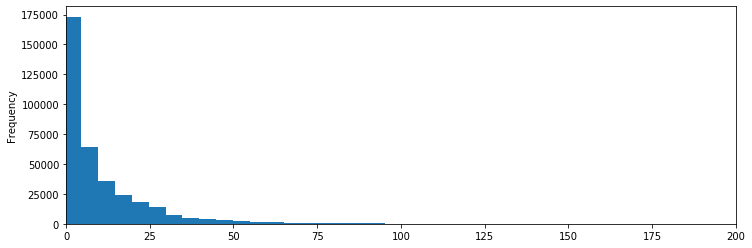

In [11]:
visits['duration'].plot.hist(bins=150, figsize=(12,4), xlim=(0,200))

In [12]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on='uid')

In [13]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

visits['cohort_lifetime'] = visits['start_ts'].astype('datetime64[M]') - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
cohorts.tail()

,first_activity_month,cohort_lifetime,uid
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15708
76,2018-04-01,1,760
77,2018-05-01,0,15271


In [14]:
lifetime = cohorts[cohorts['cohort_lifetime'] == 0]

initial_users = lifetime[['first_activity_month','uid']]
initial_users = initial_users.rename(columns={'uid': 'cohort_users'})

cohorts = cohorts.merge(initial_users, on='first_activity_month')
cohorts.rename(columns={'uid': 'all_users'}, inplace=True)
cohorts['retention'] = cohorts['all_users'] / cohorts['cohort_users']
cohorts = cohorts.query('cohort_lifetime != 0')
cohorts.head(10)

,first_activity_month,cohort_lifetime,all_users,cohort_users,retention
1,2017-06-01,1,1043,13257,0.078675
2,2017-06-01,2,712,13257,0.053707
3,2017-06-01,3,814,13257,0.061402
4,2017-06-01,4,909,13257,0.068568
5,2017-06-01,5,947,13257,0.071434
6,2017-06-01,6,809,13257,0.061024
7,2017-06-01,7,766,13257,0.057781
8,2017-06-01,8,694,13257,0.052350
9,2017-06-01,9,674,13257,0.050841
10,2017-06-01,10,539,13257,0.040658


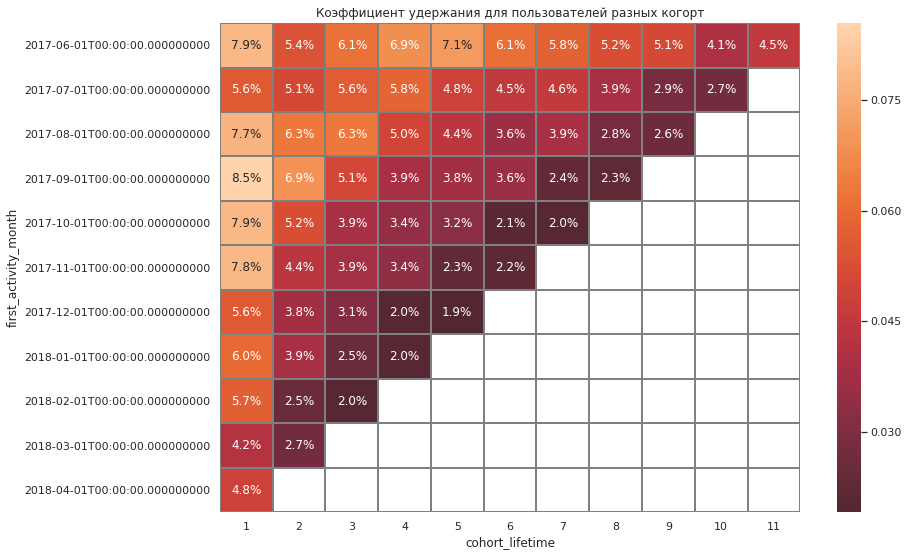

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt


retention_pivot = cohorts.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='retention', aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Коэффициент удержания для пользователей разных когорт')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', center=0)

Коэффициент удержания крайне низкий для всех когорт независимо от времени жизни. Как правило, коэффициент находится между 2% и 10%. Таким образом, можно с уверенностью утверждать, что пользователи редко возвращаются на сайт после первого посещения.

In [16]:
mean_retention = retention_pivot.mean(axis=0)[1]
print('Средний коэффициент удержания за первый месяц равен {:.1%}'.format(mean_retention))

Средний коэффициент удержания за первый месяц равен 6.5%


In [17]:
users = (visits.sort_values(by = ['uid', 'start_ts'])
               .groupby('uid')
               .agg({'start_ts' : 'first', 'source_id': 'first', 'device': 'first'})
               .rename(columns = {'start_ts' : 'acquisition_ts'}))

users = users.rename(columns={'device': 'first_device', 'source_id': 'first_source'}).reset_index()
visits_for_retention = visits.merge(users, on='uid')
visits_for_retention = (visits_for_retention
                        .groupby(['cohort_lifetime', 'first_source'])
                        .agg({'uid': 'nunique'})
                        .reset_index())
cohort_users = visits_for_retention.query('cohort_lifetime == 0')[['uid', 'first_source']].rename(columns={'uid': 'cohort_users'})
visits_for_retention = visits_for_retention.merge(cohort_users, on=['first_source'], how='left').rename(columns={'uid': 'all_users'})
visits_for_retention['retention'] = visits_for_retention['all_users'] / visits_for_retention['cohort_users']
visits_for_retention = visits_for_retention.query('cohort_lifetime !=0')
visits_for_retention.head()

,cohort_lifetime,first_source,all_users,cohort_users,retention
7,1,1,954,9470,0.100739
8,1,2,1681,17617,0.095419
9,1,3,4002,66116,0.060530
10,1,4,3913,72347,0.054087
11,1,5,2167,49238,0.044011


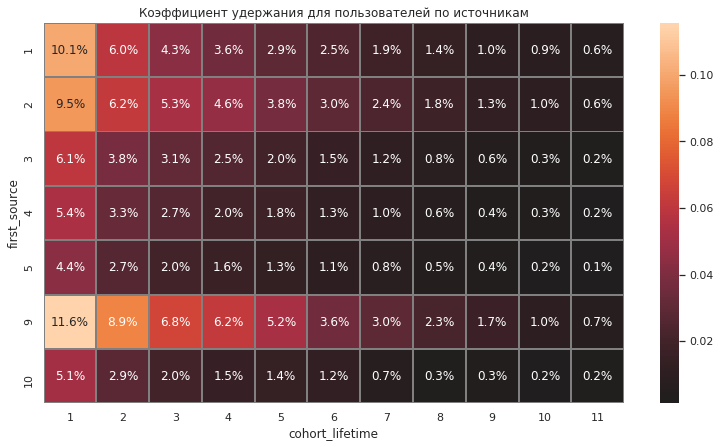

In [18]:
retention_by_source_pivot = visits_for_retention.pivot_table(index='first_source', columns='cohort_lifetime', values='retention', aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 7))
plt.title('Коэффициент удержания для пользователей по источникам')
sns.heatmap(retention_by_source_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', center=0)

Из всех источников самый высокий коэффициент удержания у источников 1,2 и 9.

In [19]:
visits_for_retention_new = visits.merge(users, on='uid')
visits_for_retention_new = (visits_for_retention_new
                        .groupby(['cohort_lifetime', 'first_device'])
                        .agg({'uid': 'nunique'})
                        .reset_index())
cohort_users = visits_for_retention_new.query('cohort_lifetime == 0')[['uid', 'first_device']].rename(columns={'uid': 'cohort_users'})
visits_for_retention_new = visits_for_retention_new.merge(cohort_users, on=['first_device'], how='left').rename(columns={'uid': 'all_users'})
visits_for_retention_new['retention'] = visits_for_retention_new['all_users'] / visits_for_retention_new['cohort_users']
visits_for_retention_new = visits_for_retention_new.query('cohort_lifetime != 0')
visits_for_retention_new.head()

,cohort_lifetime,first_device,all_users,cohort_users,retention
2,1,desktop,10015,160773,0.062293
3,1,touch,3799,67366,0.056393
4,2,desktop,6465,160773,0.040212
5,2,touch,2247,67366,0.033355
6,3,desktop,5191,160773,0.032288


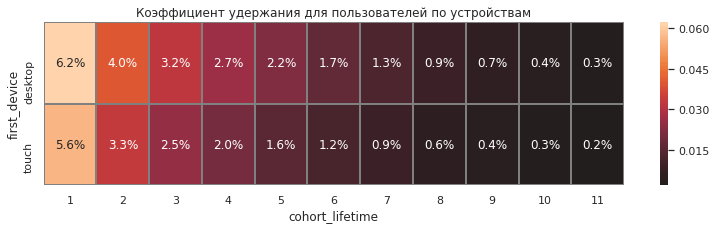

In [20]:
retention_by_device_pivot = visits_for_retention_new.pivot_table(index='first_device', columns='cohort_lifetime', values='retention', aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 3))
plt.title('Коэффициент удержания для пользователей по устройствам')
sns.heatmap(retention_by_device_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', center=0)

Коэффициент удержания с мобильных устройств и ПК не сильно отличается. Однако пользователи ПК всё же возвращаются сравнительно чаще.

### Продажи
#### Когда люди начинают покупать?

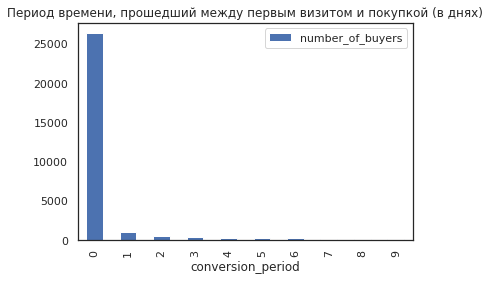

In [21]:
first_purchase_date = orders.groupby('uid').agg({'buy ts': 'min'}).reset_index()
first_purchase_date['buy ts'] = first_purchase_date['buy ts']
first_purchase_date.columns = ['uid', 'first_purchase_ts']
#print(orders_by_uid)
first_activity_and_purchase = first_purchase_date.merge(first_activity_date, on='uid')

first_activity_and_purchase['conversion_period'] = first_activity_and_purchase['first_purchase_ts'] - first_activity_and_purchase['first_activity_date']
first_activity_and_purchase['conversion_period'] = first_activity_and_purchase['conversion_period'] / np.timedelta64(1,'D')
first_activity_and_purchase['conversion_period'] = first_activity_and_purchase['conversion_period'].astype('int')

conversion_pivot = first_activity_and_purchase.pivot_table(index='conversion_period', values='uid', aggfunc='count').reset_index()
conversion_pivot.columns = ['conversion_period', 'number_of_buyers']
conversion_pivot = conversion_pivot[conversion_pivot['number_of_buyers'] > 1]
conversion_pivot.head(10).plot(kind='bar', x='conversion_period', y='number_of_buyers', title='Период времени, прошедший между первым визитом и покупкой (в днях)')

На графике видно, что абсолютное большинство пользователей совершают покупки в первый же день посещения сайта.

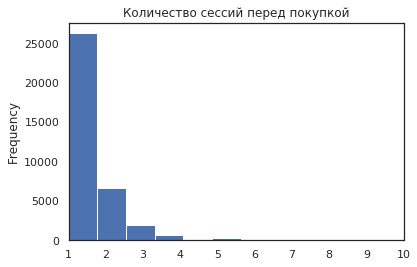

In [22]:
activity_info = visits[['uid', 'first_activity_date', 'start_ts']]
activity_info = activity_info.merge(first_purchase_date, on='uid')

activity_info = activity_info.query('first_purchase_ts >= start_ts')
sessions_count = activity_info.groupby(['uid', 'first_purchase_ts']).agg({'start_ts': 'count'}).reset_index()
sessions_count['start_ts'].plot.hist(xlim=(1,10), bins=200, title='Количество сессий перед покупкой')

Абсолютное большинство пользователей покупают в течение 1 сессии. Однако часть посетителей покупает в течение 2 сессии.

#### Сколько раз покупают за период?

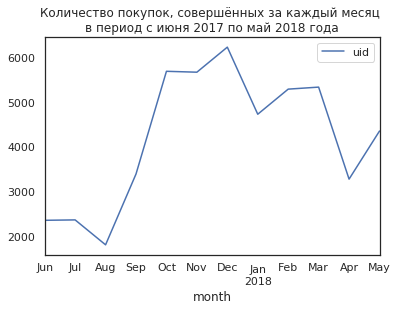

In [23]:
orders['month'] = orders['buy ts'].astype('datetime64[M]')

limit = np.datetime64('2018-06-01')
orders = orders.query('month != @limit')

orders_grouped_by_month = orders.groupby('month').agg({'uid': 'count'})

orders_grouped_by_month.plot(title='Количество покупок, совершённых за каждый месяц \nв период с июня 2017 по май 2018 года')

В месяц пользователи совершают от 2000 до 6000 покупок в зависимости от сезона. Больше всего покупок пришлось на период с октября на декабрь.

In [24]:
orders_by_user = orders.groupby('uid')['revenue'].count()
print('В среднем один пользователь совершает {:.1f} покупок'.format(orders_by_user.mean()))

В среднем один пользователь совершает 1.4 покупок


#### Какой средний чек?

In [25]:
mean_revenue = orders['revenue'].mean()
print('Средний чек для одной покупки {:.2f}'.format(mean_revenue))

Средний чек для одной покупки 5.00


#### Сколько денег приносят? (LTV)

In [26]:
orders['order_month'] = orders['buy ts'].astype('datetime64[M]')

first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [27]:
orders_first_month = pd.merge(orders,first_orders, on='uid')
cohorts_new = orders_first_month.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts_new, on='first_order_month')

report['gp'] = report['revenue']
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['gp'] / report['n_buyers']

result = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean').round(2)

result = result.cumsum(axis=1).fillna('')
result

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5,5.93,7,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


In [28]:
final_result = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')

m6_cum_ltv = final_result.mean(axis=0).cumsum()[5]
print('Средний LTV за 6 месяцев равен', m6_cum_ltv.round(2))

Средний LTV за 6 месяцев равен 7.28


### Маркетинг

#### Сколько денег потратили? Всего / на каждый источник / по времени

In [29]:
print('Всего потрачено: {} рубль'.format(costs['costs'].sum().astype('int')))

Всего потрачено: 329131 рубль


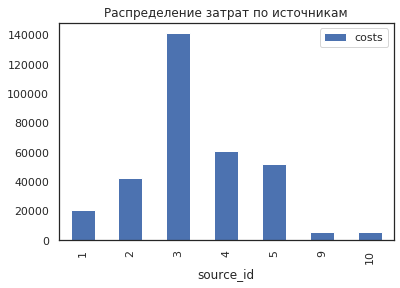

In [30]:
costs_by_source = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
costs_by_source.plot(kind='bar', x='source_id', y='costs', title='Распределение затрат по источникам')

Около половины затрат пришлось на источник 3. Меньше всего маркетологи вложили в источники 9 и 10. 

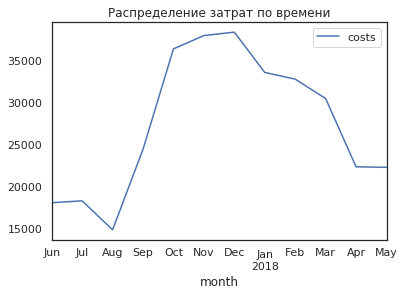

In [31]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_by_time = costs.groupby('month').agg({'costs': 'sum'}).reset_index()
costs_by_time.plot(x='month', y='costs', title='Распределение затрат по времени')

Меньше всего на маркетинг было потрачено в августе (около 15000). Больше всего - в декабре, более 35000.  Этот график коррелирует с графиком распределения покупок по времени: точки максимума и минимума, а также крутой подъём с августа по декабрь совпадают.

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [32]:
users = (visits.sort_values(by = ['uid', 'start_ts'])
               .groupby('uid')
               .agg({'start_ts' : 'first', 'source_id': 'first', 'device': 'first'})
               .rename(columns = {'start_ts' : 'first_ts'})).reset_index()

users['acquisition_date'] = users['first_ts'].dt.date
users['acquisition_month'] = users['first_ts'].astype('datetime64[M]') 

costs = costs.rename(columns={'dt': 'acquisition_date'})

orders_with_device_and_source = orders.merge(users, on='uid')[['uid', 'source_id', 'device', 'acquisition_date']]

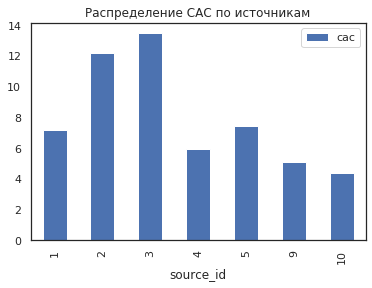

In [33]:
orders_by_source = orders_with_device_and_source.groupby('source_id').agg({'uid':'nunique'}).reset_index()
orders_by_source.columns = ['source_id','n_buyers']

source_orders_and_costs = pd.merge(orders_by_source, costs_by_source, on='source_id')
source_orders_and_costs['cac'] = source_orders_and_costs['costs'] / source_orders_and_costs['n_buyers']

source_orders_and_costs.plot(kind='bar', x='source_id', y='cac', title='Распределение САС по источникам')

Стоимость привлечения покупателей выше всего у источника 3. Самая низкая САС у источника 10.

In [34]:
total_costs = costs['costs'].sum()
total_users = orders['uid'].nunique()
mean_cost_per_user = total_costs / total_users
print('Средняя стоимость привлечения одного покупателя равна', mean_cost_per_user.round(2))

Средняя стоимость привлечения одного покупателя равна 9.01


In [37]:
#группируем таблицу для объединения с затратами
orders_with_source = (orders_with_device_and_source
                            .set_index(['source_id', 'acquisition_date'])
                            .join(costs.set_index(['source_id', 'acquisition_date']), how = 'left')
                            .reset_index())

#добавляем стоимость приобретения индивидуального пользователя
costs_by_date = (orders_with_source
                                    .groupby(['source_id', 'acquisition_date'])
                                    .agg({'uid': 'nunique', 'costs': 'max'})
                                    .rename(columns = {'uid': 'users'})
                                    .reset_index())
costs_by_date.head()

,source_id,acquisition_date,users,costs
0,1,2017-06-01,24,75.20
1,1,2017-06-02,12,62.25
2,1,2017-06-03,8,36.53
3,1,2017-06-04,6,55.00
4,1,2017-06-05,20,57.08


In [38]:
#CAC по устройствам
costs_by_date['acqusition_cost'] = costs_by_date['costs'] / costs_by_date['users']

orders_with_source = orders_with_source.merge(costs_by_date,
                                    on=['source_id', 'acquisition_date'], how='left').reset_index(drop=True)
                                 
cac_by_device = (orders_with_source.groupby('device')
                 .agg({'acqusition_cost': 'mean'})
                 .round(2))
cac_by_device

,acqusition_cost
device,
desktop,8.88
touch,8.68


CAC для мобильного устройства выше, чем для ПК. Однако разница небольшая.

#### На сколько окупились расходы? (ROI)

In [39]:
report['roi'] = report['ltv'] / mean_cost_per_user

total_roi = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='roi', 
    aggfunc='mean').round(2)

total_roi.cumsum(axis=1).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.52,0.57,0.62,0.73,0.84,0.92,1.03,1.09,1.15,1.22,1.28,1.31
2017-07-01,0.67,0.71,0.78,0.82,0.84,0.86,0.87,0.89,0.91,0.93,0.95,
2017-08-01,0.59,0.64,0.69,0.73,0.78,0.81,0.83,0.87,0.9,0.92,,
2017-09-01,0.63,0.75,0.81,1.25,1.29,1.36,1.44,1.47,1.49,,,
2017-10-01,0.56,0.62,0.64,0.66,0.68,0.69,0.7,0.71,,,,
2017-11-01,0.57,0.61,0.63,0.67,0.69,0.7,0.71,,,,,
2017-12-01,0.53,0.56,0.66,0.78,0.81,0.85,,,,,,
2018-01-01,0.46,0.49,0.52,0.54,0.55,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


In [40]:
total_roi.cumsum(axis=1).mean(axis=0)

age
0     0.547500
1     0.599091
2     0.646000
3     0.743333
4     0.810000
5     0.884286
6     0.930000
7     1.006000
8     1.112500
9     1.023333
10    1.115000
11    1.310000
dtype: float64

В среднем когорты окупаются за первые 8 месяцев.

- Расчёты по источникам

In [41]:
#таблица с указанием источника первого посещения для каждого пользователя
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')
visits_new = visits.query('first_activity_month == activity_month')

first_sources = visits_new[['uid', 'source_id', 'start_ts']].drop_duplicates().reset_index(drop=True)
first_sources_new = first_sources.groupby('uid').agg({'start_ts': 'min'})

first_visit_sources = first_sources.merge(first_sources_new, on=['start_ts', 'uid'], how='right')
first_visit_sources = first_visit_sources[['uid', 'source_id']]
first_visit_sources = first_visit_sources.rename(columns={'source_id': 'first_source'})

visits_with_first_source = visits.merge(first_visit_sources, on='uid')

In [42]:
#LTV по источникам
orders_with_sources = orders_first_month.merge(first_visit_sources, on='uid')
orders_with_sources['age'] = (
    (orders_with_sources['order_month'] - orders_with_sources['first_order_month']) / np.timedelta64(1, 'M')).astype('int')

cohorts_by_source = orders_with_sources.groupby(
    ['first_source','age']).agg({'revenue': 'sum'}).reset_index()
cohorts_by_source = cohorts_by_source.query('age <= 5')

cohort_size_by_source = orders_with_sources.groupby('first_source').agg({'uid': 'nunique'}).reset_index()
cohort_size_by_source = cohort_size_by_source.rename(columns={'uid': 'n_clients'})

cohorts_by_source = cohorts_by_source.merge(cohort_size_by_source, on='first_source')
cohorts_by_source['ltv'] = cohorts_by_source['revenue'] / cohorts_by_source['n_clients']
ltv_by_sources = cohorts_by_source.pivot_table(
                                            index='first_source', 
                                            columns='age', 
                                            values='ltv', 
                                            aggfunc='mean')
ltv_by_sources.cumsum(axis=1).round(2)

age,0,1,2,3,4,5
first_source,,,,,,
1,6.70,7.18,8.17,8.71,9.12,9.38
2,7.34,8.20,10.94,11.64,12.34,12.72
3,4.65,4.78,4.94,5.03,5.10,5.14
4,4.68,4.75,4.88,5.00,5.10,5.29
5,4.94,5.13,6.68,6.82,7.02,7.30
9,4.03,4.20,4.55,4.70,4.90,5.00
10,3.19,3.23,3.27,3.31,3.32,3.33


In [43]:
ltv_and_cac_by_source = cohorts_by_source.merge(source_orders_and_costs, left_on='first_source', right_on='source_id')
ltv_and_cac_by_source['roi'] = ltv_and_cac_by_source['ltv'] / ltv_and_cac_by_source['cac']

roi_report = ltv_and_cac_by_source.pivot_table(
                                            index='first_source', 
                                            columns='age', 
                                            values='roi', 
                                            aggfunc='mean')

roi_report.cumsum(axis=1).round(2)

age,0,1,2,3,4,5
first_source,,,,,,
1,0.93,1.00,1.14,1.21,1.27,1.30
2,0.60,0.67,0.90,0.95,1.01,1.04
3,0.34,0.35,0.37,0.37,0.38,0.38
4,0.79,0.80,0.82,0.84,0.86,0.89
5,0.66,0.69,0.89,0.91,0.94,0.98
9,0.80,0.83,0.90,0.93,0.97,0.99
10,0.73,0.74,0.75,0.75,0.76,0.76


За первые полгода окупились только источники 1 и 2. Все остальные кроме 3 и 10 близки к тому, чтобы окупиться. Источники 3 и 10 приносят наименьший ROI.   

- Расчёты по типу устройств

In [44]:
first_devices = visits_new[['uid', 'device', 'start_ts']].drop_duplicates().reset_index(drop=True)

first_devices_new = first_devices.groupby('uid').agg({'start_ts': 'min'})
first_visit_devices = first_devices.merge(first_devices_new, on=['start_ts', 'uid'], how='right')
first_visit_devices = first_visit_devices[['uid', 'device']]
first_visit_devices = first_visit_devices.rename(columns={'device': 'first_device'})

visits_with_first_device = visits.merge(first_visit_devices, on='uid')

clients_with_device = visits_with_first_device[['uid', 'first_device', 'first_activity_month']].drop_duplicates().reset_index(drop=True)

In [45]:
device_cohort_size = orders_with_device_and_source.groupby('device').agg({'uid': 'nunique'}).rename(columns={'uid' : 'n_clients'})
device_cohort_size

,n_clients
device,
desktop,29209
touch,7312


In [46]:
#LTV
orders_by_device = orders_first_month.merge(clients_with_device, on='uid')
orders_by_device['lifetime'] = ((orders_by_device['order_month'] - orders_by_device['first_activity_month']) / np.timedelta64(1, 'M')).round().astype('int')

cohorts_by_device = (orders_by_device[['lifetime', 'first_device', 'revenue']]
                     .groupby(['first_device', 'lifetime'])
                     .agg({'revenue': 'sum'})
                     .query('lifetime <= 5')
                     .reset_index())

device_cohort_size = device_cohort_size.reset_index().rename(columns={'device' : 'first_device'})

cohorts_by_device = cohorts_by_device.merge(device_cohort_size, on='first_device')
cohorts_by_device['ltv'] = cohorts_by_device['revenue'] / cohorts_by_device['n_clients']

ltv_by_devices = cohorts_by_device.pivot_table(
                                            index='first_device', 
                                            columns='lifetime', 
                                            values='ltv', 
                                            aggfunc='mean')
ltv_by_devices.cumsum(axis=1).round(2)

lifetime,0,1,2,3,4,5
first_device,,,,,,
desktop,4.01,4.64,5.09,5.89,6.22,6.51
touch,3.44,4.12,4.41,4.63,4.80,4.97


In [47]:
#ROI
cac_by_device = cac_by_device.reset_index().rename(columns={'device' : 'first_device'})
ltv_and_cac_by_device = (cohorts_by_device
                         .merge(cac_by_device, on='first_device'))
ltv_and_cac_by_device['roi'] = ltv_and_cac_by_device['ltv'] / ltv_and_cac_by_device['acqusition_cost']

roi_report = ltv_and_cac_by_device.pivot_table(
                                            index='first_device', 
                                            columns='lifetime', 
                                            values='roi', 
                                            aggfunc='mean')

roi_report.cumsum(axis=1).round(2)

lifetime,0,1,2,3,4,5
first_device,,,,,,
desktop,0.45,0.52,0.57,0.66,0.70,0.73
touch,0.40,0.47,0.51,0.53,0.55,0.57


Покупатели, совершающие покупки с ПК, окупаются лучше, чем те, кто заходит с мобильных устройств.

## Выводы

Чтобы оптимизировать затраты на маркетинг, следует учесть следующие результаты анализа:
1. Обратить внимание на источники 3 и 10. Они оказываются крайне неэффективными. При этом на источник 3 тратятся значительные средства.
2. С точки зрения окупаемости лидирует источник 1. Возможно, стоит перераспределить средства в его пользу.
3. Источники 2 и 9 стоит продолжать финансировать, т.к. коэффициент удержания у них сравнительно высок, а окупаемость средняя.
4. Затраты на маркетинг отвечают сезонности спроса. С этой точки зрения всё в порядке.
5. Интерфейс сайта удобен для совершения покупок. Об этом говорит тот факт, что абсолютное большинство пользователей совершают покупку в течение одного дня после факта перехода на сайт, а точнее в течение 1 сессии.
6. Количество покупателей с мобильных устройств значительно ниже по сравнению с ПК. Это может быть связано с тем, что с мобильных устройств реже заходят на сайт. Возможно, стоит проверить удобство мобильного интерфейса для пользователя.

Немного цифр:
1. Retention Rate за 1 месяц - 6,5%
2. Средний LTV за полгода - 7,28
4. Средний САС - 9,01
3. В среднем когорты окупаются (ROI > 1) за первые 8 месяцев